In [1]:
import pandas as pd 
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import xarray
import xrspatial.multispectral as ms

# загружаем подготовленный набор изображений и меток с путями
df = pd.read_csv('data/train_metadata_my.csv')
df.head()

chip_id  location                   datetime                   cloudpath  \
0    adwp  Chifunfu  2020-04-29 08:20:47+00:00  az://./train_features/adwp   
1    adwu  Chifunfu  2020-04-29 08:20:47+00:00  az://./train_features/adwu   
2    adwz  Chifunfu  2020-04-29 08:20:47+00:00  az://./train_features/adwz   
3    adxp  Chifunfu  2020-04-29 08:20:47+00:00  az://./train_features/adxp   
4    aeaj  Chifunfu  2020-04-29 08:20:47+00:00  az://./train_features/aeaj   

   year                                           B02_path  \
0  2020  J:\CloudCover\data\data\train_features\adwp\B0...   
1  2020  J:\CloudCover\data\data\train_features\adwu\B0...   
2  2020  J:\CloudCover\data\data\train_features\adwz\B0...   
3  2020  J:\CloudCover\data\data\train_features\adxp\B0...   
4  2020  J:\CloudCover\data\data\train_features\aeaj\B0...   

                                            B03_path  \
0  J:\CloudCover\data\data\train_features\adwp\B0...   
1  J:\CloudCover\data\data\train_features\adwu\B0...   
2  J:\CloudCover\data\data\train_features\adwz\B0...   
3  J:\CloudCover\data\data\train_features\adxp\B0...   
4  J:\CloudCover\data\data\train_features\aeaj\B0...   

                                            B04_path  \
0  J:\CloudCover\data\data\train_features\adwp\B0...   
1  J:\CloudCover\data\data\train_features\adwu\B0...   
2  J:\CloudCover\data\data\train_features\adwz\B0...   
3  J:\CloudCover\data\data\train_features\adxp\B0...   
4  J:\CloudCover\data\data\train_features\aeaj\B0...   

                                            B08_path  \
0  J:\CloudCover\data\data\train_features\adwp\B0...   
1  J:\CloudCover\data\data\train_features\adwu\B0...   
2  J:\CloudCover\data\data\train_features\adwz\B0...   
3  J:\CloudCover\data\data\train_features\adxp\B0...   
4  J:\CloudCover\data\data\train_features\aeaj\B0...   

                                      label_path  
0  J:\CloudCover\data\data\train_labels\adwp.tif  
1  J:\CloudCover\data\data\train_labels\adwu.tif  
2  J:\CloudCover\data\data\train_labels\adwz.tif  
3  J:\CloudCover\data\data\train_labels\adxp.tif  
4  J:\CloudCover\data\data\train_labels\aeaj.tif

In [32]:
def load_chip(row, transforms = None):
    data={
        "chip_id":row.iloc[0],
        "image":None,
        "label":None
    }
    band_arrs = []
    for band in row[5:9]:
        with rasterio.open(band) as b:
            band_arr = b.read(1).astype("float32")
        band_arrs.append(band_arr)

    # #VARI = (Green - Red)/(Green + Red - Blue)
    # vari = (band_arrs[1] - band_arrs[2])/(band_arrs[1] + band_arrs[2] - band_arrs[0] + 1)
    # band_arrs.append(vari)

    # NDVI = (iRed - Red)/(iRed + Red)индекс растительности
    # ndvi = (band_arrs[3] - band_arrs[2])/(band_arrs[3] + band_arrs[2] + 1)
    # band_arrs.append(ndvi)
    
    # # NDSI = (Green - iRed)/(Green + iRed)индекс снега
    # ndsi = (band_arrs[1] - band_arrs[3])/(band_arrs[1] + band_arrs[3] + 1)
    # band_arrs.append(ndsi)

    # # Оттенки серого
    # gray = (band_arrs[0] + band_arrs[1] + band_arrs[2])/3
    # band_arrs.append(gray)

    x_arr = np.stack(band_arrs, axis=-1)
    # для меток
    with rasterio.open(row[9]) as lp:
        y_arr = lp.read(1).astype("float32")
        
    # Apply data augmentations, if provided
    if transforms:
        t = transforms(image = x_arr, mask = y_arr)
        x_arr = t["image"]
        y_arr = t["mask"] 

    data["image"] = np.transpose(x_arr, [2, 0, 1])
    data["label"] = y_arr
    
    return data

In [3]:
def get_label_mean(path):
    with rasterio.open(path) as lp:
        label = lp.read(1).astype("float32")
    return label.mean()

In [8]:
df['label_mean'] = df["label_path"].apply(get_label_mean)

In [9]:
df_clear = df[(df['label_mean'] < 1) & (df['label_mean'] > 0)]
df_clear.head()

chip_id  location                   datetime                   cloudpath  \
0    adwp  Chifunfu  2020-04-29 08:20:47+00:00  az://./train_features/adwp   
1    adwu  Chifunfu  2020-04-29 08:20:47+00:00  az://./train_features/adwu   
5    aeap  Chifunfu  2020-04-29 08:20:47+00:00  az://./train_features/aeap   
6    aebi  Chifunfu  2020-04-29 08:20:47+00:00  az://./train_features/aebi   
8    aeej  Chifunfu  2020-04-29 08:20:47+00:00  az://./train_features/aeej   

   year                                           B02_path  \
0  2020  J:\CloudCover\data\data\train_features\adwp\B0...   
1  2020  J:\CloudCover\data\data\train_features\adwu\B0...   
5  2020  J:\CloudCover\data\data\train_features\aeap\B0...   
6  2020  J:\CloudCover\data\data\train_features\aebi\B0...   
8  2020  J:\CloudCover\data\data\train_features\aeej\B0...   

                                            B03_path  \
0  J:\CloudCover\data\data\train_features\adwp\B0...   
1  J:\CloudCover\data\data\train_features\adwu\B0...   
5  J:\CloudCover\data\data\train_features\aeap\B0...   
6  J:\CloudCover\data\data\train_features\aebi\B0...   
8  J:\CloudCover\data\data\train_features\aeej\B0...   

                                            B04_path  \
0  J:\CloudCover\data\data\train_features\adwp\B0...   
1  J:\CloudCover\data\data\train_features\adwu\B0...   
5  J:\CloudCover\data\data\train_features\aeap\B0...   
6  J:\CloudCover\data\data\train_features\aebi\B0...   
8  J:\CloudCover\data\data\train_features\aeej\B0...   

                                            B08_path  \
0  J:\CloudCover\data\data\train_features\adwp\B0...   
1  J:\CloudCover\data\data\train_features\adwu\B0...   
5  J:\CloudCover\data\data\train_features\aeap\B0...   
6  J:\CloudCover\data\data\train_features\aebi\B0...   
8  J:\CloudCover\data\data\train_features\aeej\B0...   

                                      label_path  label_mean  
0  J:\CloudCover\data\data\train_labels\adwp.tif    0.479294  
1  J:\CloudCover\data\data\train_labels\adwu.tif    0.636658  
5  J:\CloudCover\data\data\train_labels\aeap.tif    0.843662  
6  J:\CloudCover\data\data\train_labels\aebi.tif    0.943565  
8  J:\CloudCover\data\data\train_labels\aeej.tif    0.912453

In [4]:
# для каждой строки можем получить изображение и метку
load_chip(df.iloc[0])["image"].shape

(4, 512, 512)

In [49]:
# добавим аугументацию
import albumentations as A

a1 = A.RandomRotate90(p=1)
a2 = A.RandomSizedCrop((256,512), 512,512, p=0.8)
# a3 = A.RandomBrightnessContrast(p=0.8)
# a4 = A.ChannelShuffle(p=0.8)

a_comp = A.Compose([a1, a2])

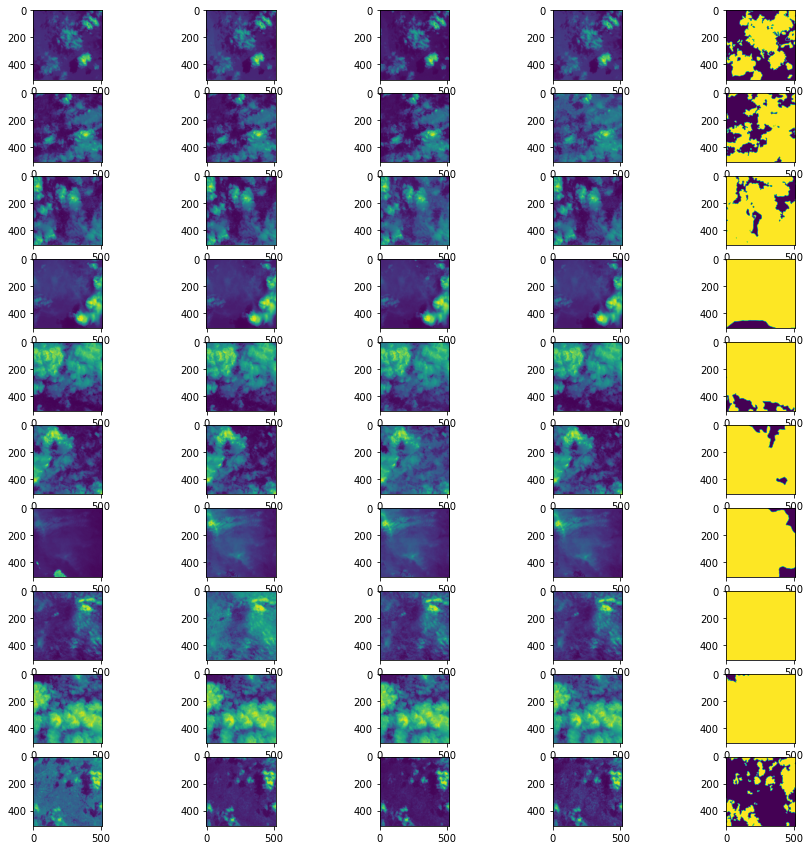

In [40]:
# применение с показом
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(15,15))

for i in range(0, 10):
    chip = load_chip(df_clear.iloc[i], transforms=a_comp)
    axes[i, 0].imshow(chip["image"][0]);
    axes[i, 1].imshow(chip["image"][1]);
    axes[i, 2].imshow(chip["image"][2]);
    axes[i, 3].imshow(chip["image"][3]);
    # axes[i, 4].imshow(chip["image"][4]);
    # axes[i, 5].imshow(chip["image"][5]);
    # axes[i, 6].imshow(chip["image"][6]);
    axes[i, 4].imshow(chip["label"]);

In [51]:
#применение с сохранением - наконец то - нужно добавить проверку при загрузке
import os
# fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(15,15))

for i in range(0, 100):
    chip = load_chip(df_clear.iloc[i], transforms=a_comp)
    if not os.path.exists(f"data_aug/train_features/{chip['chip_id']}"):
        os.mkdir(f"data_aug/train_features/{chip['chip_id']}")
    plt.imsave(f"data_aug/train_features/{chip['chip_id']}/B02.tif", chip["image"][0], format='tiff')
    plt.imsave(f"data_aug/train_features/{chip['chip_id']}/B03.tif", chip["image"][1], format='tiff')
    plt.imsave(f"data_aug/train_features/{chip['chip_id']}/B04.tif", chip["image"][2], format='tiff')
    plt.imsave(f"data_aug/train_features/{chip['chip_id']}/B08.tif", chip["image"][3], format='tiff')
    # axes[i, 0].imshow(chip["image"][0]);
    # axes[i, 1].imshow(chip["image"][1]);
    # axes[i, 2].imshow(chip["image"][2]);
    # axes[i, 3].imshow(chip["image"][3]);
    # axes[i, 4].imshow(chip["image"][4]);
    # axes[i, 5].imshow(chip["image"][5]);
    # axes[i, 6].imshow(chip["image"][6]);
    # axes[i, 4].imshow(chip["label"]);

1.0


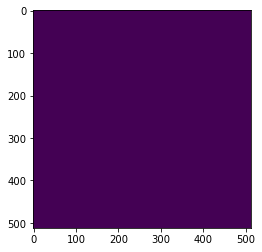

In [18]:
l1 = load_chip(df.iloc[2])["label"]
plt.imshow(l1)
print(l1.mean())

AttributeError: 'numpy.ndarray' object has no attribute 'mode'

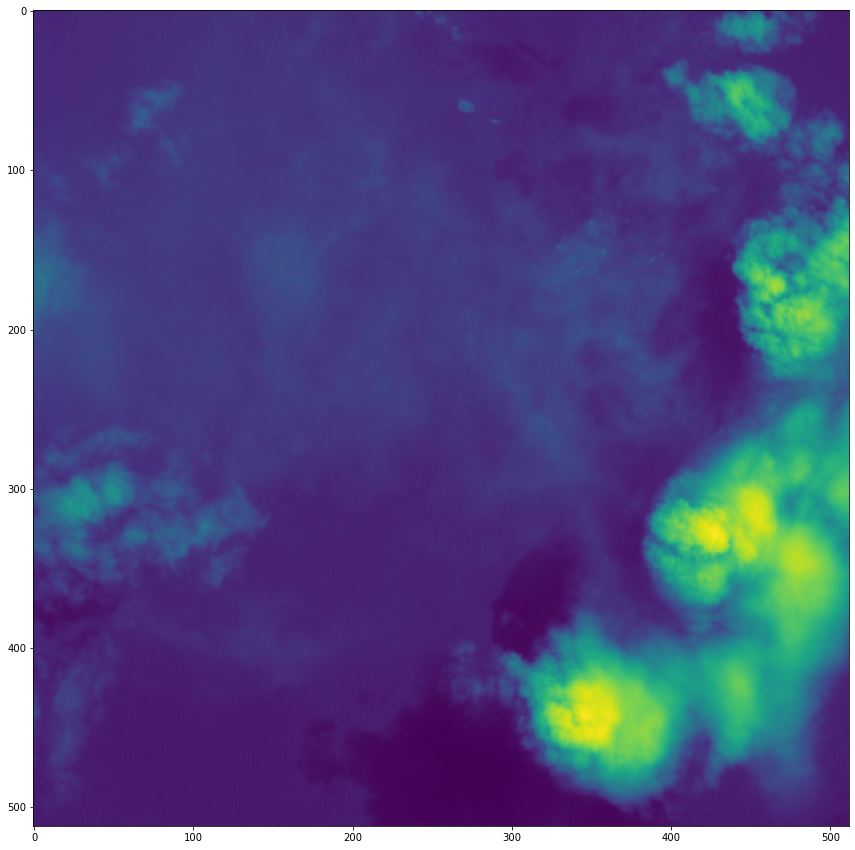

In [19]:
plt.gcf().set_size_inches(15,15)
plt.imshow(load_chip(df.iloc[6])["image"][0])

In [20]:
chip = load_chip(df.iloc[6])
ndvi = (chip['image'][3] - chip['image'][2])/(chip['image'][3] + chip['image'][2])

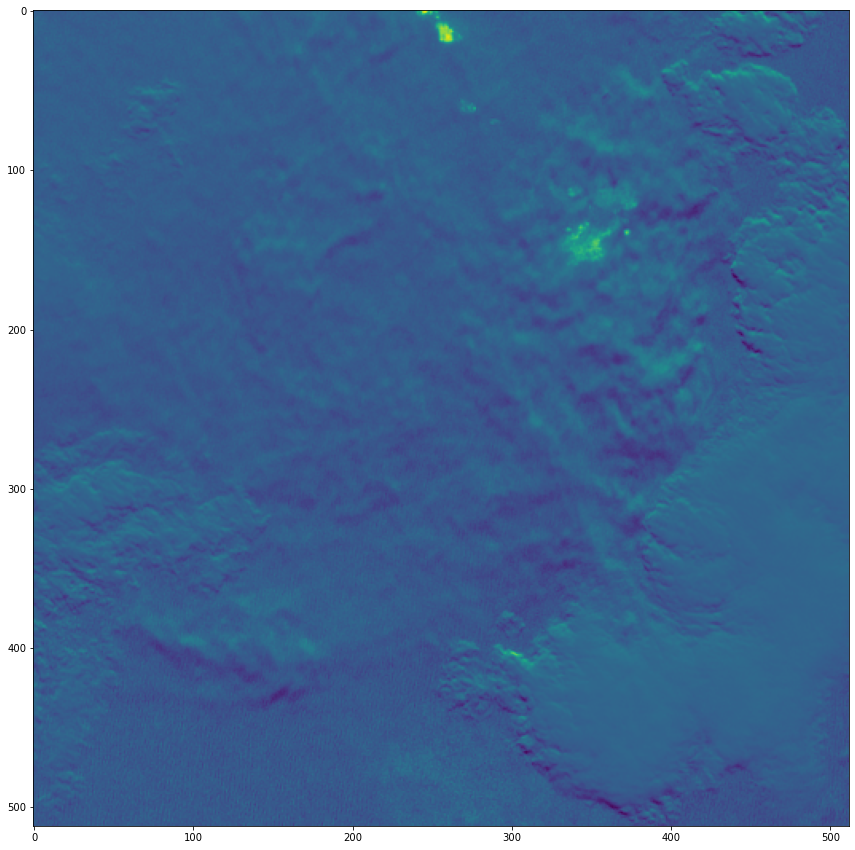

In [21]:
plt.gcf().set_size_inches(15,15)
plt.imshow(ndvi)

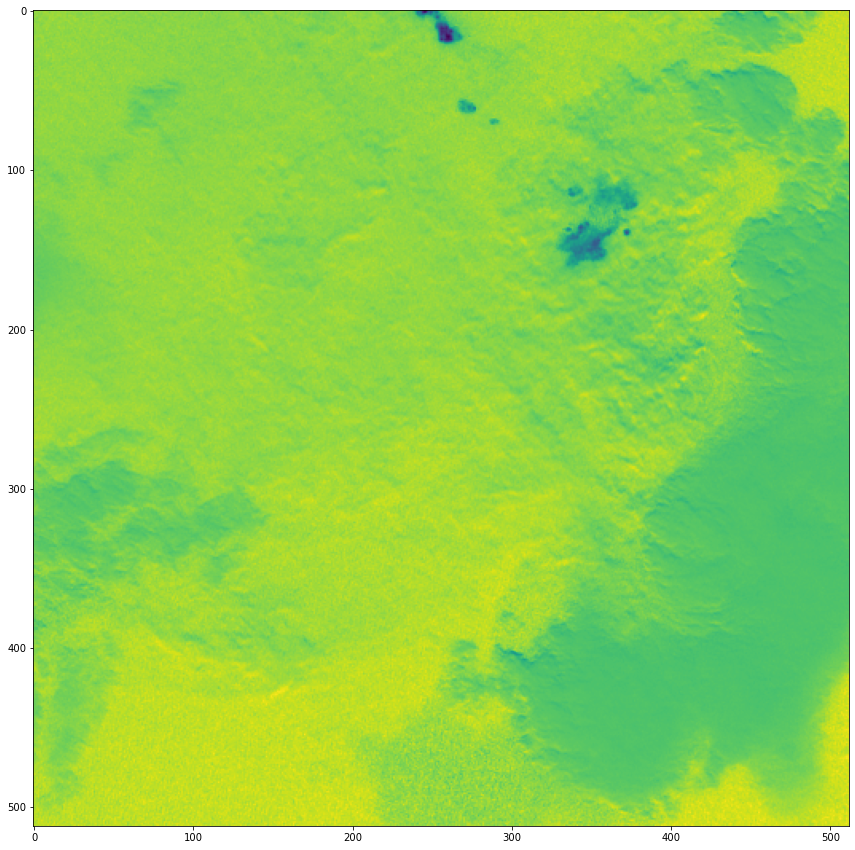

In [24]:
#ndsi
chip = load_chip(df.iloc[6])
ndsi = (chip['image'][1] - chip['image'][3])/(chip['image'][1] + chip['image'][3])
plt.gcf().set_size_inches(15,15)
plt.imshow(ndsi)

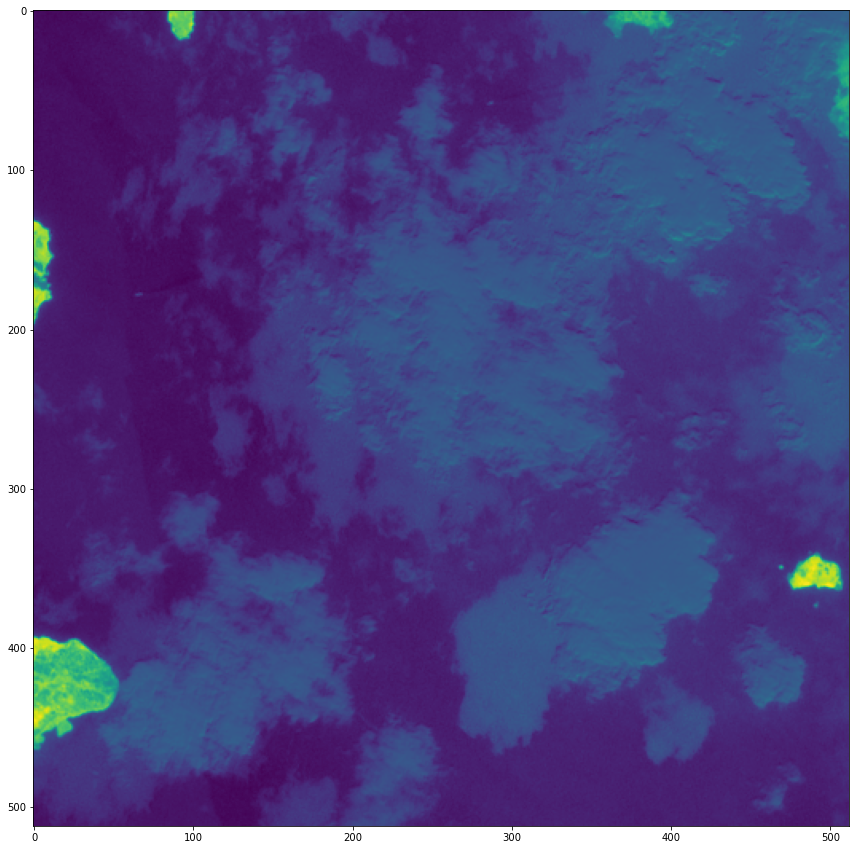

In [29]:
# NDVI (Normalized Difference Vegetation Index) - нормализованный относительный индекс растительности
chip = load_chip(df.iloc[0])
ndvi = (chip['image'][3] - chip['image'][2])/(chip['image'][3] + chip['image'][2])
plt.gcf().set_size_inches(15,15)
plt.imshow(ndvi)

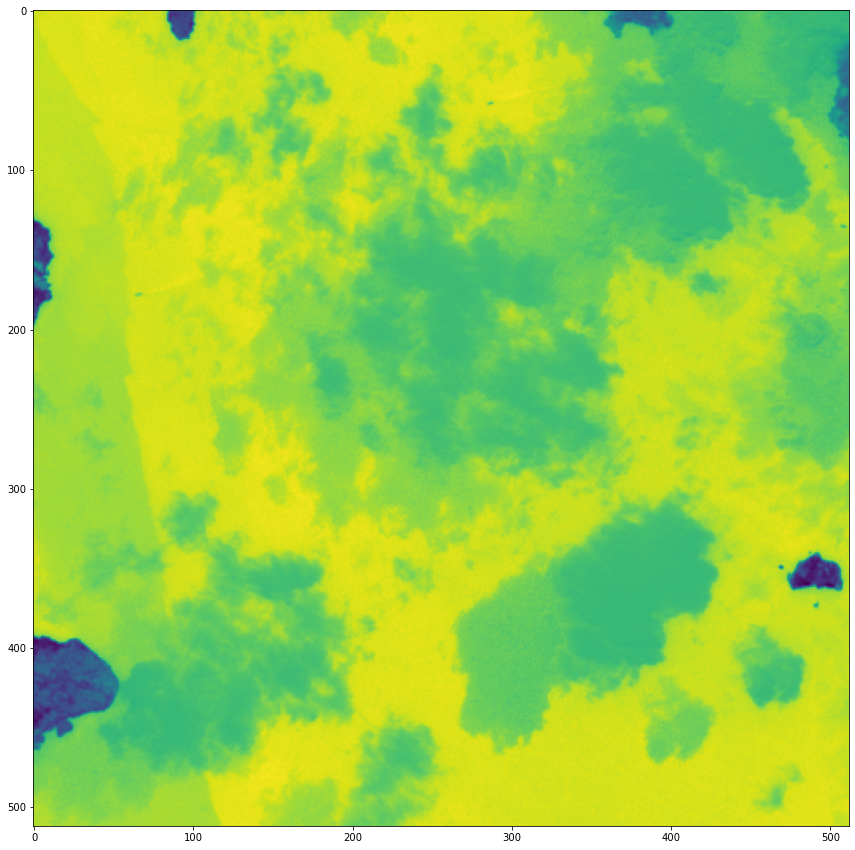

In [30]:
chip = load_chip(df.iloc[0])
ndsi = (chip['image'][1] - chip['image'][3])/(chip['image'][1] + chip['image'][3])
plt.gcf().set_size_inches(15,15)
plt.imshow(ndsi)

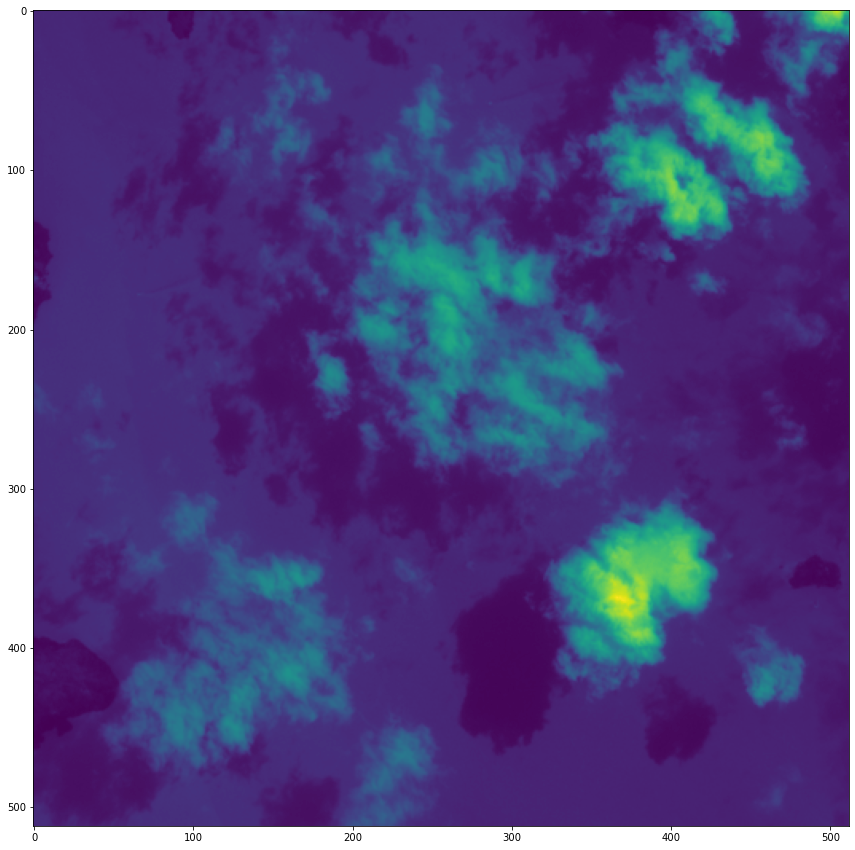

In [31]:
chip = load_chip(df.iloc[0])
plt.gcf().set_size_inches(15,15)
plt.imshow(chip['image'][0])

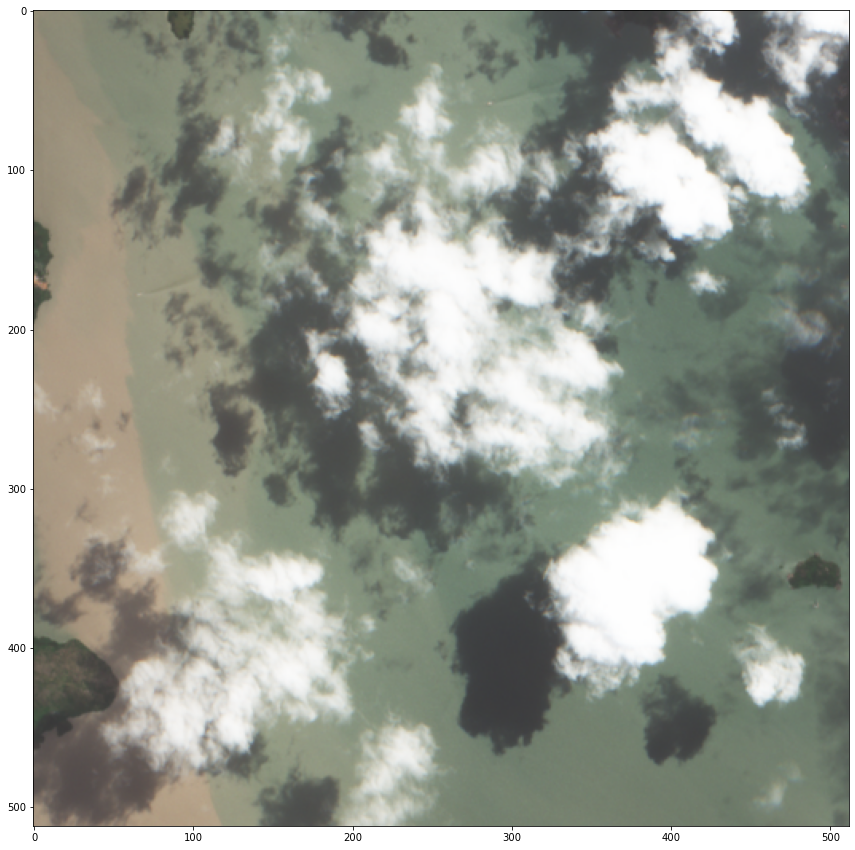

In [35]:
r_ = xarray.DataArray(chip['image'][2], dims=["y", "x"])
g_ = xarray.DataArray(chip['image'][1], dims=["y", "x"])
b_ = xarray.DataArray(chip['image'][0], dims=["y", "x"])
true_img = ms.true_color(r=r_, g=g_, b=b_)

plt.gcf().set_size_inches(15,15)
plt.imshow(true_img)

In [55]:
# grayscale
import torchvision.transforms as Trans
import torchvision.transforms.functional as TransF
import albumentations as A

# a1 = A.RandomSizedCrop((128,256), 512,512)
a1 = A.ToGray()
chip = load_chip(df.iloc[0])

chip_t =  np.transpose(chip["image"][:3], [1, 2, 0])

x_arr_transform6 = a1(image=chip_t)["image"]

# x_arr_transform6 = np.transpose(x_arr_transform6, [2, 0, 1])
# plt.imshow(x_arr_transform6)
# gray = ImageOps.grayscale()
# plt.gcf().set_size_inches(15,15)
# plt.imshow(gray)
x_arr_transform6.shape

(512, 512, 3)